I'll be working with a Kaggle [dataset](https://www.kaggle.com/shellshock1911/us-commercial-aviation-industry-metrics/version/2) with flight information over time for different airports, aggregated in periods of one month each. More specifically, I'll be using the data for JFK.

In [76]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa
%matplotlib inline

In [58]:
# Dropping three na rows at the bottom
flights = pd.read_csv("all_airlines-jfk.csv").dropna()

In [59]:
flights.head()

,Date,ASM_Domestic,ASM_International,Flights_Domestic,Flights_International,Passengers_Domestic,Passengers_International,RPM_Domestic,RPM_International
0,2002-10-01,1424548,3107840.0,7021,3674.0,612442,598710.0,976138,2203691.0
1,2002-11-01,1347850,2868665.0,6717,3439.0,581676,556622.0,902604,1992474.0
2,2002-12-01,1445339,3055525.0,6980,3642.0,699241,670301.0,1138102,2372750.0
3,2003-01-01,1437965,3042557.0,6896,3632.0,621399,540250.0,984425,1989507.0
4,2003-02-01,1263576,2521645.0,5919,3001.0,568540,465651.0,871958,1668722.0


In [60]:
flights = flights.set_index('Date')

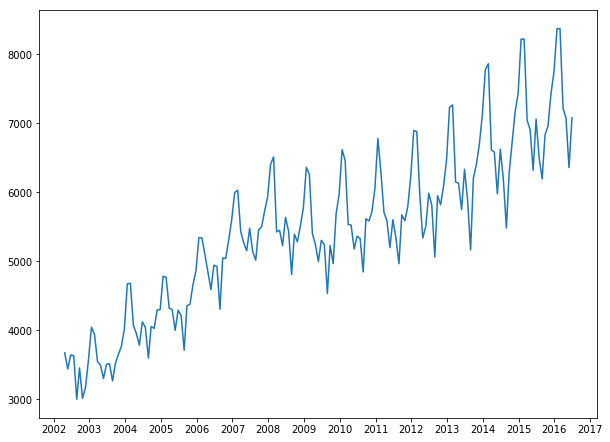

In [61]:
import matplotlib.dates as mdates

fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(1,1,1)
plt.plot(pd.to_datetime(flights.index),flights['Flights_International'])
ax.xaxis.set_major_locator(mdates.DayLocator(interval=365))
plt.show()

Let's use international flights, which shows a steady trend increase with definite seasonality/randomness that should provide an interesting modeling exercise.

First, we'll try to get a stationary series. First we'll start with a single difference of 1.

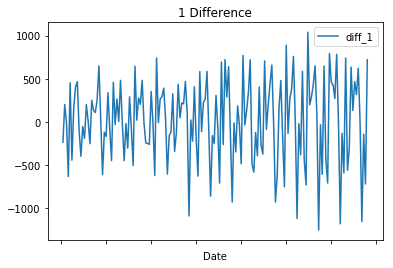

In [62]:
flights['diff_1'] = flights['Flights_International'] - flights['Flights_International'].shift()
flights.plot(y='diff_1')
plt.title('1 Difference')
plt.show()

This looks OK, but we know there's some seasonality involved and the swings above become more dramatic over time, so we're not quite as stationary as we could be. I'll be referencing this [blog post](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/) from Sean Abu and use the same seasonality differencing he does.

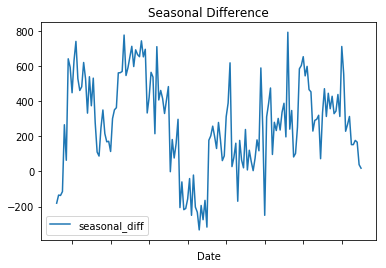

In [63]:
# The cycle takes course over the course of a year, so we'll use 365 for the shift
flights['seasonal_diff'] = flights['Flights_International'] - flights['Flights_International'].shift(12)
flights.plot(y='seasonal_diff')
plt.title('Seasonal Difference')
plt.show()

Not quite stationary, so let's take a first difference of this seasonal difference.

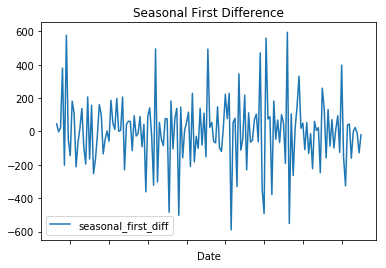

In [64]:
flights['seasonal_first_diff'] = flights['diff_1'] - flights['diff_1'].shift(12)
flights.plot(y='seasonal_first_diff')
plt.title('Seasonal First Difference')
plt.show()

Now we're pretty stationary!

The next step is to run the partial autocorrelation function (PACF) on our seasonal first difference.

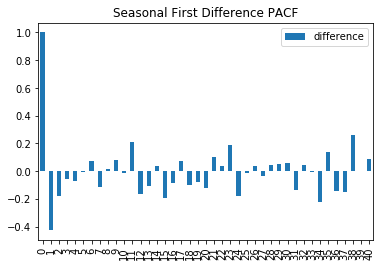

In [70]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(flights['seasonal_first_diff'][13:]))
x_acf.plot(kind='bar')
plt.title("Seasonal First Difference PACF")
plt.legend(['difference'])

/usr/local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


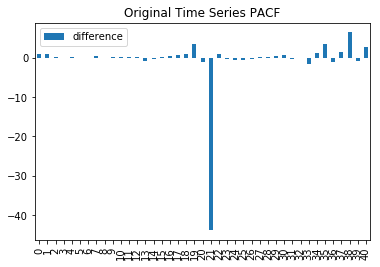

In [108]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(flights['Flights_International']))
x_acf.plot(kind='bar')
plt.title("Original Time Series PACF")
plt.legend(['difference'])

It's not immediately apparent to me the number of differences/lags to include, and I'm particularly unsure about what's going on with the original time series PACF. Let's experiment with some ARIMA models and see how we do.

We'll technically be using a different model from statsmodels that has seasonality functionality. It's called SARIMAX. We'll start off with a model that has:

**1. (0,1,0) for the ARIMA component and (1,1,1,12) for the seasonal component**

In [77]:
mod = sm.tsa.statespace.SARIMAX(flights['Flights_International'], trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
mod_fit = mod.fit()
print(mod_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:              Flights_International   No. Observations:                  171
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -1048.452
Date:                            Fri, 04 May 2018   AIC                           2102.904
Time:                                    16:37:42   BIC                           2112.329
Sample:                                10-01-2002   HQIC                          2106.728
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.1787      0.171      1.048      0.295      -0.156       0.513
ma.S.L12      -0.6481      0.163   

**2. (1,1,1) for the ARIMA component and (2,1,2,12) for the seasonal component**

In [79]:
mod = sm.tsa.statespace.SARIMAX(flights['Flights_International'], trend='n', order=(1,1,1), seasonal_order=(2,1,2,12))
mod_fit = mod.fit()
print(mod_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:              Flights_International   No. Observations:                  171
Model:             SARIMAX(1, 1, 1)x(2, 1, 2, 12)   Log Likelihood               -1032.699
Date:                            Fri, 04 May 2018   AIC                           2079.397
Time:                                    16:42:30   BIC                           2101.389
Sample:                                10-01-2002   HQIC                          2088.321
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0337      0.162     -0.208      0.835      -0.350       0.283
ma.L1         -0.4202      0.157   

**3. (2,1,2) for the ARIMA component and (3,1,3,12) for the seasonal component**

In [101]:
mod = sm.tsa.statespace.SARIMAX(flights['Flights_International'], trend='n', order=(2,1,2), seasonal_order=(3,1,3,12))
mod_fit = mod.fit()
print(mod_fit.summary())

/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:              Flights_International   No. Observations:                  171
Model:             SARIMAX(2, 1, 2)x(3, 1, 3, 12)   Log Likelihood               -1032.168
Date:                            Fri, 04 May 2018   AIC                           2086.337
Time:                                    16:53:40   BIC                           2120.895
Sample:                                10-01-2002   HQIC                          2100.359
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2462      2.482      0.099      0.921      -4.618       5.111
ar.L2          0.0951      0.223   

**4. (1,1,1) for the ARIMA component and (0,1,0,12) for the seasonal component**

In [102]:
mod = sm.tsa.statespace.SARIMAX(flights['Flights_International'], trend='n', order=(1,1,1), seasonal_order=(0,1,0,12))
mod_fit = mod.fit()
print(mod_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:              Flights_International   No. Observations:                  171
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 12)   Log Likelihood               -1044.337
Date:                            Fri, 04 May 2018   AIC                           2094.674
Time:                                    16:54:24   BIC                           2104.099
Sample:                                10-01-2002   HQIC                          2098.498
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0692      0.135     -0.511      0.610      -0.335       0.196
ma.L1         -0.4438      0.126   

**5. (1,1,1) for the ARIMA component and (1,1,1,12) for the seasonal component**

In [104]:
mod = sm.tsa.statespace.SARIMAX(flights['Flights_International'], trend='n', order=(1,1,1), seasonal_order=(1,1,1,12))
mod_fit = mod.fit()
print(mod_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:              Flights_International   No. Observations:                  171
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1033.806
Date:                            Fri, 04 May 2018   AIC                           2077.611
Time:                                    16:55:04   BIC                           2093.319
Sample:                                10-01-2002   HQIC                          2083.985
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0232      0.156     -0.149      0.882      -0.329       0.283
ma.L1         -0.4362      0.150   

We get the best results from #5, because that produces the best AIC. It's certainly worth noting that this was far from an exhaustive gridsearch - I was really just trying out random numbers. But let's run with this one for our model. Let's calculate how the AIC compares to the next best value of 2079.

In [107]:
np.exp((2077.611-2079.397)/2)

0.4094256315983982

Interesting...so it's unlikely there's really that much of a difference between these two "best performers" of ours. It's also worthwhile to note that some of our coefficients seem to have pretty low high P values. Only the moving average from our ARIMA and seasonal components seem to be the ones that really make a difference.

Since it wouldn't be any fun otherwise, let's take a look at how the predictions look mapped on to the real results!

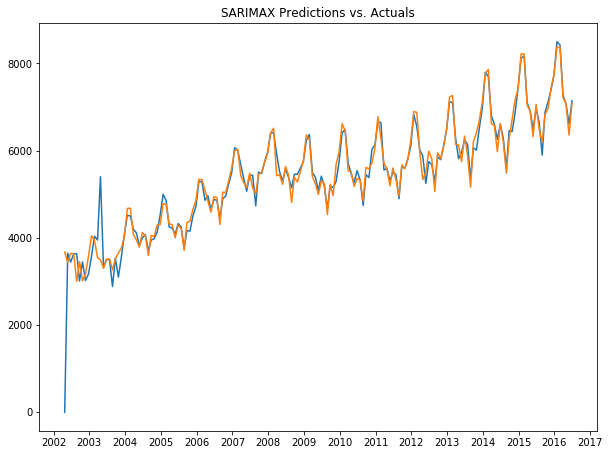

In [100]:
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(1,1,1)
plt.plot(pd.to_datetime(flights.index), mod_fit.predict(),pd.to_datetime(flights.index), flights['Flights_International'])
ax.xaxis.set_major_locator(mdates.DayLocator(interval=365))
plt.title("SARIMAX Predictions vs. Actuals")
plt.show()

Not bad! I'm sure there's room for improvement, but this looks decent.